<a href="https://colab.research.google.com/github/SeunghyeChae/tmdhey/blob/main/GAN_xray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Xray GAN

In [1]:
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
import torchvision

- 생성자와 판별자를 연결하는 gan 네트워크를 만듦
 gan(x) = discriminator(generator(x))
- gan 네트워크는 잠재 공간의 벡터를 판별자의 평가로 매핑
- 판별자는 생성자가 잠재 공간의 벡터를 디코딩한 것이 얼마나 현실적인지를 평가
- '진짜'/'가짜' 레이블과 함께 진짜 이미지와 가짜 이미지 샘플을 사용해 판별자를 훈련함. 일반적인 이미지 분류 모델을 훈련하는 것과 동일
- 생성자를 훈련하려면 gan 모델의 손실에 대한 생성자 가중치의 그래디언트를 사용함. (== 매 단계 마다 생성자에 의해 디코딩된 이미지를 판별자가 '진짜'로 분류하도록 만드는 방향으로 생성자의 가중치를 이동한다는 뜻). 즉, 판별자를 속이도록 생성자를 훈련

In [2]:
# 생성자

# input: (batch_size * chs_in * hegith_in * width_in)
# Output: (batch_size, chs_out, hegith_out, width_out)
# h_out = (hegith_in -1) * stride - 2 * padding + kernel

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            
            # Hidden Layer 1
            nn.ConvTranspose2d(in_channels=100, 
                               out_channels=512,
                               kernel_size=4,
                               stride=1,
                               padding=0,
                               bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            
            # Hidden Layer 2
            nn.ConvTranspose2d(in_channels=512,
                               out_channels=256,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            
            # Hidden Layer 3
            nn.ConvTranspose2d(in_channels=256,
                               out_channels=128,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            
            # Hidden Layer 4
            nn.ConvTranspose2d(in_channels=128,
                               out_channels=64,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            
            # Output Layer
            nn.ConvTranspose2d(in_channels=64, 
                               out_channels=1,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.main(x)
        return x

In [3]:
# 판별자
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(
            
            # (batch_size, 1, 64, 64)
            nn.Conv2d(in_channels=1,
                      out_channels=64,
                      kernel_size=4,
                      stride=2,
                      padding=1, 
                      bias=False),
            nn.LeakyReLU(negative_slope=0.2),
            
            # (batch_size, 64, 32, 32)
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(negative_slope=0.2),
            
            # (batch_size, 128, 16, 16)
            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.LeakyReLU(negative_slope=0.2),
            
            # (batch_size, 256, 8, 8)
            nn.Conv2d(in_channels=256,
                      out_channels=512,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(negative_slope=0.2),
            
            # (batch_size, 512, 4, 4)
            nn.Conv2d(in_channels=512,
                      out_channels=1,
                      kernel_size=4,
                      stride=1,
                      padding=0,
                      bias=False),
            
            # (batch_size, 1, 1, 1)
            nn.Sigmoid()
        )
        
        
    def forward(self, x):
        x = self.main(x)
        return x

In [4]:
G = Generator()
G(torch.randn(12, 100, 1, 1)).shape

torch.Size([12, 1, 64, 64])

In [5]:
D = Discriminator()
D(torch.randn(14, 1, 64, 64)).shape

torch.Size([14, 1, 1, 1])

In [6]:
def build_data_loader(batch_size):
    dataset = torchvision.datasets.ImageFolder(
        root='/content/drive/MyDrive/cakd_colab/2차플젝/2차 데이터 원본/데이터 원본/image',
        # root='/content/drive/MyDrive/cakd_colab/python_practice/.kaggle',
        transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize(64), 
            torchvision.transforms.CenterCrop(64), 
            torchvision.transforms.Grayscale(), 
            torchvision.transforms.ToTensor(), 
        ]))
    
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(images):
    img = torchvision.utils.make_grid(images, normalize=True)
    npy_img = img.numpy()
    plt.imshow(np.transpose(npy_img, (1, 2, 0)),
               interpolation='nearest')
    plt.show()

In [8]:
# for data, _ in build_data_loader(5):
#     test_images = data
#     break
    
# print(test_images.shape)
# show_images(test_images)

In [9]:
compute_loss = nn.BCELoss()

In [10]:
# # 얘로하면 좀 이상해요~ 120정도부터 이상해요
# n_epochs = 150
# batch_size = 5

# 이걸로 하면 좀 빠를거같고 
n_epochs = 110
batch_size = 15

# # 이건 그 후에 해볼거예욤
# n_epochs = 100
# batch_size = 5


In [11]:
gpu = torch.device(0)
G = G.to(gpu)
D = D.to(gpu)

In [12]:
optimizer_d = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_g = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [13]:
data_loader = build_data_loader(batch_size)
test_noise = torch.randn((8, 100, 1, 1)).to(gpu)

Epoch: 0/110
Example images:


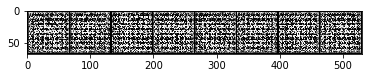

Epoch: 0	Batch: 165/166
Loss G: 7.788302898406982
Loss D: 0.001713750883936882
Epoch: 1/110
Example images:


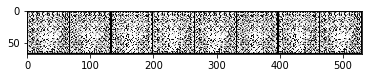

Epoch: 1	Batch: 165/166
Loss G: 7.006773471832275
Loss D: 0.0889420136809349
Epoch: 2/110
Example images:


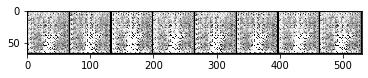

Epoch: 2	Batch: 165/166
Loss G: 1.7394956350326538
Loss D: 1.3483129739761353
Epoch: 3/110
Example images:


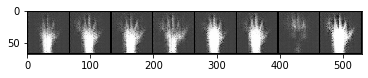

Epoch: 3	Batch: 165/166
Loss G: 6.057845592498779
Loss D: 0.3364323377609253
Epoch: 4/110
Example images:


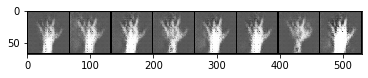

Epoch: 4	Batch: 165/166
Loss G: 3.955587387084961
Loss D: 0.14282579720020294
Epoch: 5/110
Example images:


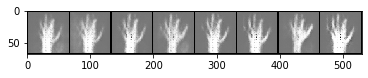

Epoch: 5	Batch: 165/166
Loss G: 6.7404327392578125
Loss D: 0.4775717854499817
Epoch: 6/110
Example images:


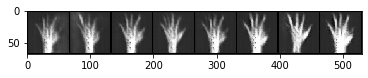

Epoch: 6	Batch: 165/166
Loss G: 5.6113200187683105
Loss D: 0.61989426612854
Epoch: 7/110
Example images:


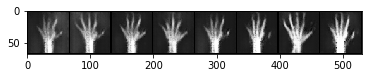

Epoch: 7	Batch: 165/166
Loss G: 4.395061492919922
Loss D: 0.200277179479599
Epoch: 8/110
Example images:


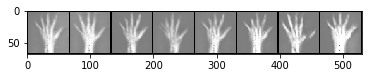

Epoch: 8	Batch: 165/166
Loss G: 3.8688278198242188
Loss D: 0.22238196432590485
Epoch: 9/110
Example images:


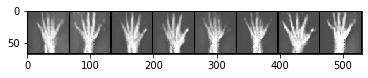

Epoch: 9	Batch: 165/166
Loss G: 4.199671268463135
Loss D: 0.19965168833732605
Epoch: 10/110
Example images:


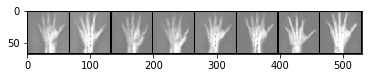

Epoch: 10	Batch: 165/166
Loss G: 7.222143650054932
Loss D: 0.6058791875839233
Epoch: 11/110
Example images:


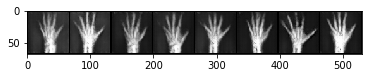

Epoch: 11	Batch: 165/166
Loss G: 4.168498516082764
Loss D: 0.08221529424190521
Epoch: 12/110
Example images:


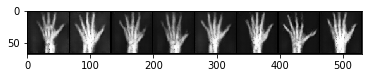

Epoch: 12	Batch: 165/166
Loss G: 4.969141483306885
Loss D: 0.49602147936820984
Epoch: 13/110
Example images:


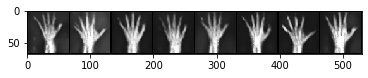

Epoch: 13	Batch: 165/166
Loss G: 4.138060569763184
Loss D: 0.07329314202070236
Epoch: 14/110
Example images:


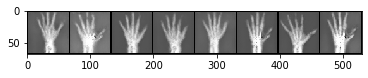

Epoch: 14	Batch: 165/166
Loss G: 6.868338108062744
Loss D: 0.42612582445144653
Epoch: 15/110
Example images:


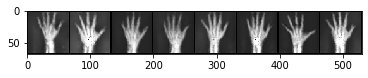

Epoch: 15	Batch: 165/166
Loss G: 5.3756632804870605
Loss D: 0.04128793627023697
Epoch: 16/110
Example images:


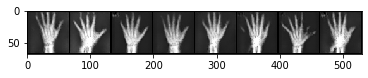

Epoch: 16	Batch: 165/166
Loss G: 4.553325176239014
Loss D: 0.06953506171703339
Epoch: 17/110
Example images:


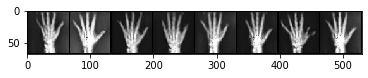

Epoch: 17	Batch: 165/166
Loss G: 6.076838970184326
Loss D: 0.019511839374899864
Epoch: 18/110
Example images:


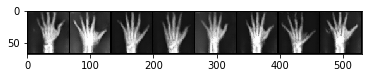

Epoch: 18	Batch: 165/166
Loss G: 6.0718841552734375
Loss D: 0.014475209638476372
Epoch: 19/110
Example images:


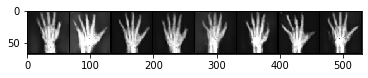

Epoch: 19	Batch: 165/166
Loss G: 2.809229612350464
Loss D: 0.15547208487987518
Epoch: 20/110
Example images:


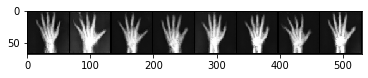

Epoch: 20	Batch: 165/166
Loss G: 5.912377834320068
Loss D: 0.03165213763713837
Epoch: 21/110
Example images:


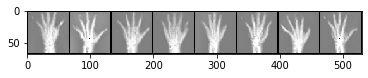

Epoch: 21	Batch: 165/166
Loss G: 5.423224925994873
Loss D: 0.06217598915100098
Epoch: 22/110
Example images:


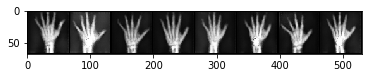

Epoch: 22	Batch: 165/166
Loss G: 5.393420219421387
Loss D: 0.07766351848840714
Epoch: 23/110
Example images:


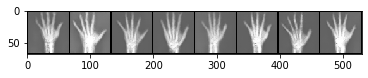

Epoch: 23	Batch: 165/166
Loss G: 5.375810146331787
Loss D: 0.018128259107470512
Epoch: 24/110
Example images:


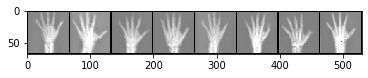

Epoch: 24	Batch: 165/166
Loss G: 4.8883161544799805
Loss D: 0.0841088742017746
Epoch: 25/110
Example images:


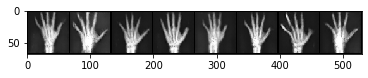

Epoch: 25	Batch: 165/166
Loss G: 7.893077850341797
Loss D: 0.0034939367324113846
Epoch: 26/110
Example images:


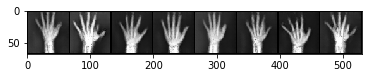

Epoch: 26	Batch: 165/166
Loss G: 4.778277397155762
Loss D: 0.037901971489191055
Epoch: 27/110
Example images:


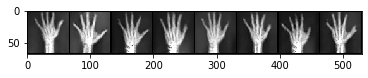

Epoch: 27	Batch: 165/166
Loss G: 4.989633083343506
Loss D: 0.0681401714682579
Epoch: 28/110
Example images:


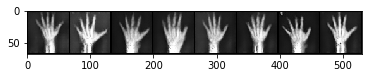

Epoch: 28	Batch: 165/166
Loss G: 5.271932125091553
Loss D: 0.01386458519846201
Epoch: 29/110
Example images:


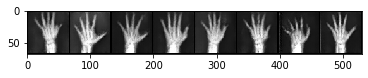

Epoch: 29	Batch: 165/166
Loss G: 8.51343822479248
Loss D: 0.0068182689137756824
Epoch: 30/110
Example images:


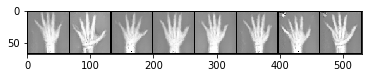

Epoch: 30	Batch: 165/166
Loss G: 3.5809998512268066
Loss D: 0.057599201798439026
Epoch: 31/110
Example images:


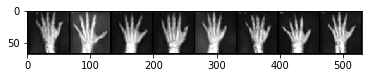

Epoch: 31	Batch: 165/166
Loss G: 4.708001613616943
Loss D: 0.01945665292441845
Epoch: 32/110
Example images:


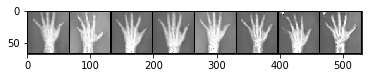

Epoch: 32	Batch: 165/166
Loss G: 6.238440990447998
Loss D: 0.003877372480928898
Epoch: 33/110
Example images:


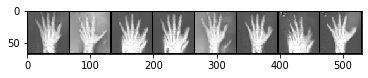

Epoch: 33	Batch: 165/166
Loss G: 4.055419921875
Loss D: 0.3205876052379608
Epoch: 34/110
Example images:


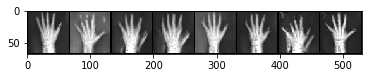

Epoch: 34	Batch: 165/166
Loss G: 13.998122215270996
Loss D: 0.08508903533220291
Epoch: 35/110
Example images:


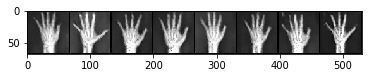

Epoch: 35	Batch: 165/166
Loss G: 7.9489359855651855
Loss D: 0.0016906423261389136
Epoch: 36/110
Example images:


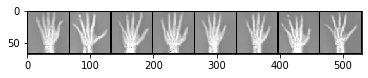

Epoch: 36	Batch: 165/166
Loss G: 4.385694980621338
Loss D: 0.03395750746130943
Epoch: 37/110
Example images:


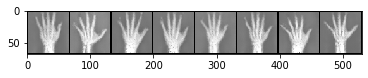

Epoch: 37	Batch: 165/166
Loss G: 6.647024631500244
Loss D: 0.002215552143752575
Epoch: 38/110
Example images:


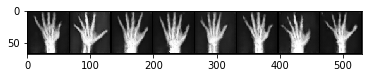

Epoch: 38	Batch: 165/166
Loss G: 9.286148071289062
Loss D: 0.0013962910743430257
Epoch: 39/110
Example images:


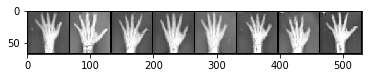

Epoch: 39	Batch: 165/166
Loss G: 14.569999694824219
Loss D: 0.0013086444232612848
Epoch: 40/110
Example images:


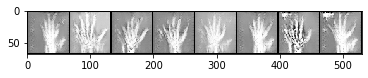

Epoch: 40	Batch: 165/166
Loss G: 4.857911109924316
Loss D: 0.05088777840137482
Epoch: 41/110
Example images:


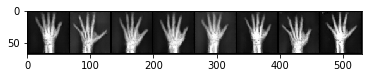

Epoch: 41	Batch: 165/166
Loss G: 4.682804107666016
Loss D: 0.14504583179950714
Epoch: 42/110
Example images:


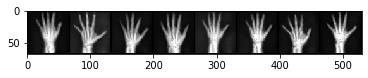

Epoch: 42	Batch: 165/166
Loss G: 4.95082426071167
Loss D: 0.088192880153656
Epoch: 43/110
Example images:


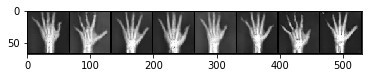

Epoch: 43	Batch: 165/166
Loss G: 5.4577765464782715
Loss D: 0.08879867941141129
Epoch: 44/110
Example images:


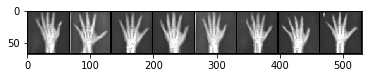

Epoch: 44	Batch: 165/166
Loss G: 6.389427185058594
Loss D: 0.05093315988779068
Epoch: 45/110
Example images:


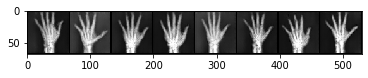

Epoch: 45	Batch: 165/166
Loss G: 6.716558933258057
Loss D: 0.008883676491677761
Epoch: 46/110
Example images:


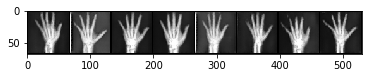

Epoch: 46	Batch: 165/166
Loss G: 9.74809455871582
Loss D: 0.003782044630497694
Epoch: 47/110
Example images:


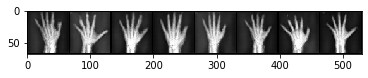

Epoch: 47	Batch: 165/166
Loss G: 9.091545104980469
Loss D: 0.005423807539045811
Epoch: 48/110
Example images:


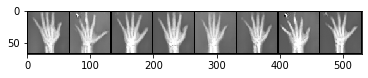

Epoch: 48	Batch: 165/166
Loss G: 4.861366271972656
Loss D: 0.035173315554857254
Epoch: 49/110
Example images:


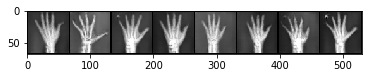

Epoch: 49	Batch: 165/166
Loss G: 6.835099697113037
Loss D: 0.003279434982687235
Epoch: 50/110
Example images:


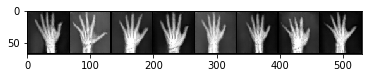

Epoch: 50	Batch: 165/166
Loss G: 5.546687126159668
Loss D: 0.01369395200163126
Epoch: 51/110
Example images:


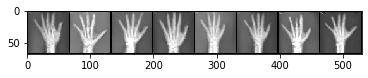

Epoch: 51	Batch: 165/166
Loss G: 12.675528526306152
Loss D: 0.00022752018412575126
Epoch: 52/110
Example images:


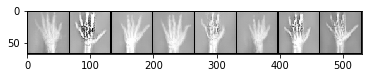

Epoch: 52	Batch: 165/166
Loss G: 6.111810684204102
Loss D: 0.0060980068519711494
Epoch: 53/110
Example images:


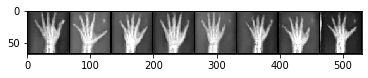

Epoch: 53	Batch: 165/166
Loss G: 8.396584510803223
Loss D: 0.0591139942407608
Epoch: 54/110
Example images:


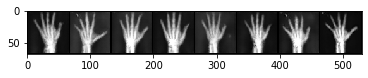

Epoch: 54	Batch: 165/166
Loss G: 4.80501651763916
Loss D: 0.03398250788450241
Epoch: 55/110
Example images:


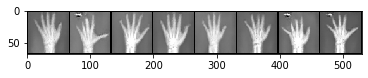

Epoch: 55	Batch: 165/166
Loss G: 9.190553665161133
Loss D: 0.003462908323854208
Epoch: 56/110
Example images:


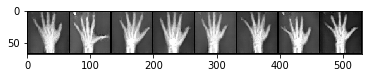

Epoch: 56	Batch: 165/166
Loss G: 6.736743450164795
Loss D: 0.004448719322681427
Epoch: 57/110
Example images:


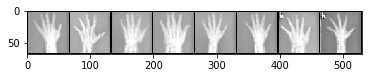

Epoch: 57	Batch: 165/166
Loss G: 5.271541595458984
Loss D: 0.028132159262895584
Epoch: 58/110
Example images:


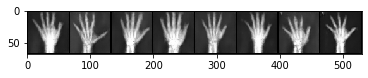

Epoch: 58	Batch: 165/166
Loss G: 5.858490467071533
Loss D: 0.15401911735534668
Epoch: 59/110
Example images:


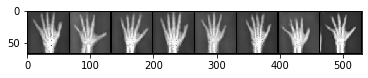

Epoch: 59	Batch: 165/166
Loss G: 8.066615104675293
Loss D: 0.009805593639612198
Epoch: 60/110
Example images:


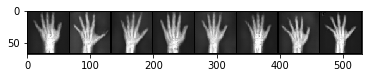

Epoch: 60	Batch: 165/166
Loss G: 5.845815181732178
Loss D: 0.06796278059482574
Epoch: 61/110
Example images:


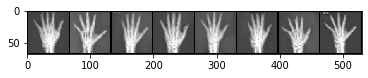

Epoch: 61	Batch: 165/166
Loss G: 8.055839538574219
Loss D: 0.0020165361929684877
Epoch: 62/110
Example images:


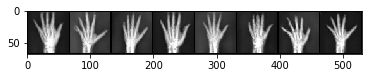

Epoch: 62	Batch: 165/166
Loss G: 5.311417579650879
Loss D: 0.0660228431224823
Epoch: 63/110
Example images:


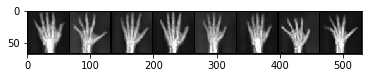

Epoch: 63	Batch: 165/166
Loss G: 5.19205904006958
Loss D: 0.032363053411245346
Epoch: 64/110
Example images:


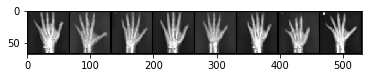

Epoch: 64	Batch: 165/166
Loss G: 6.1916913986206055
Loss D: 0.014795877039432526
Epoch: 65/110
Example images:


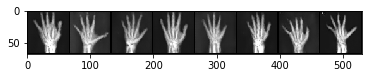

Epoch: 65	Batch: 165/166
Loss G: 6.943443298339844
Loss D: 0.373821496963501
Epoch: 66/110
Example images:


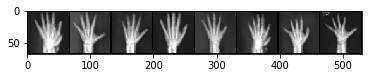

Epoch: 66	Batch: 165/166
Loss G: 5.231197834014893
Loss D: 0.061307143419981
Epoch: 67/110
Example images:


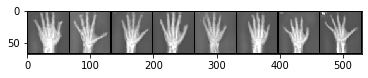

Epoch: 67	Batch: 165/166
Loss G: 9.446056365966797
Loss D: 0.00943099893629551
Epoch: 68/110
Example images:


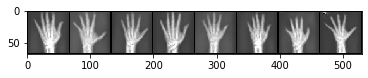

Epoch: 68	Batch: 165/166
Loss G: 8.483770370483398
Loss D: 0.007088067010045052
Epoch: 69/110
Example images:


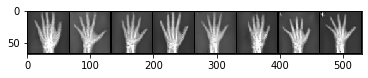

Epoch: 69	Batch: 165/166
Loss G: 5.415046215057373
Loss D: 0.04166223853826523
Epoch: 70/110
Example images:


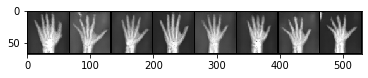

Epoch: 70	Batch: 165/166
Loss G: 8.0021333694458
Loss D: 0.001673904131166637
Epoch: 71/110
Example images:


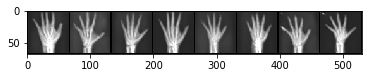

Epoch: 71	Batch: 165/166
Loss G: 10.194045066833496
Loss D: 0.0025691173505038023
Epoch: 72/110
Example images:


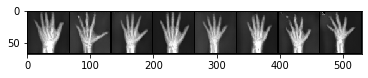

Epoch: 72	Batch: 165/166
Loss G: 8.65887451171875
Loss D: 0.004552166908979416
Epoch: 73/110
Example images:


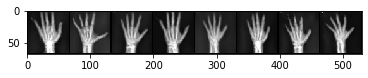

Epoch: 73	Batch: 165/166
Loss G: 6.192599296569824
Loss D: 0.02317984029650688
Epoch: 74/110
Example images:


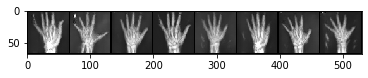

Epoch: 74	Batch: 165/166
Loss G: 6.745953559875488
Loss D: 0.018312280997633934
Epoch: 75/110
Example images:


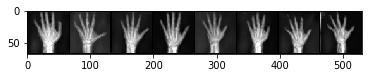

Epoch: 75	Batch: 165/166
Loss G: 5.84657621383667
Loss D: 0.046567682176828384
Epoch: 76/110
Example images:


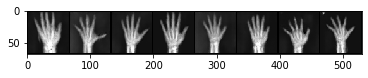

Epoch: 76	Batch: 165/166
Loss G: 8.26908016204834
Loss D: 0.002751775784417987
Epoch: 77/110
Example images:


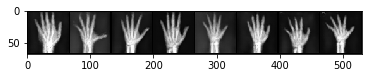

Epoch: 77	Batch: 165/166
Loss G: 7.913977146148682
Loss D: 0.003899198491126299
Epoch: 78/110
Example images:


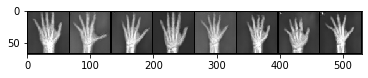

Epoch: 78	Batch: 165/166
Loss G: 6.633492469787598
Loss D: 0.009187820367515087
Epoch: 79/110
Example images:


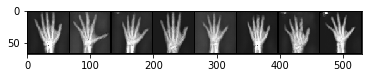

Epoch: 79	Batch: 165/166
Loss G: 5.953713417053223
Loss D: 0.0075733354315161705
Epoch: 80/110
Example images:


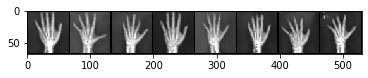

Epoch: 80	Batch: 165/166
Loss G: 6.233475685119629
Loss D: 0.048881787806749344
Epoch: 81/110
Example images:


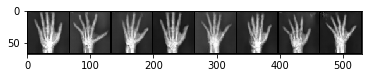

Epoch: 81	Batch: 165/166
Loss G: 8.530993461608887
Loss D: 0.4015481770038605
Epoch: 82/110
Example images:


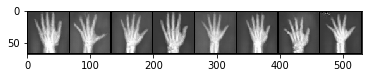

Epoch: 82	Batch: 165/166
Loss G: 7.651635646820068
Loss D: 0.003119331318885088
Epoch: 83/110
Example images:


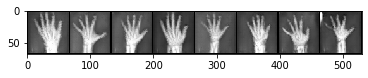

Epoch: 83	Batch: 165/166
Loss G: 5.599647045135498
Loss D: 0.04974476993083954
Epoch: 84/110
Example images:


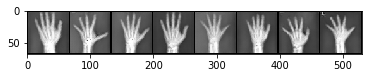

Epoch: 84	Batch: 165/166
Loss G: 6.60573673248291
Loss D: 0.09262692928314209
Epoch: 85/110
Example images:


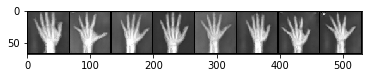

Epoch: 85	Batch: 165/166
Loss G: 13.711799621582031
Loss D: 0.0013985064579173923
Epoch: 86/110
Example images:


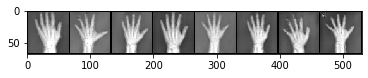

Epoch: 86	Batch: 165/166
Loss G: 9.332530975341797
Loss D: 0.001671510050073266
Epoch: 87/110
Example images:


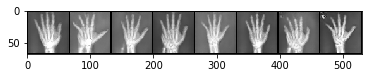

Epoch: 87	Batch: 165/166
Loss G: 17.201513290405273
Loss D: 0.016590239480137825
Epoch: 88/110
Example images:


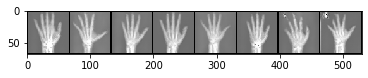

Epoch: 88	Batch: 165/166
Loss G: 9.159611701965332
Loss D: 0.03520709648728371
Epoch: 89/110
Example images:


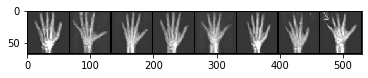

Epoch: 89	Batch: 165/166
Loss G: 7.386724948883057
Loss D: 0.005942498799413443
Epoch: 90/110
Example images:


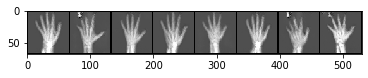

Epoch: 90	Batch: 165/166
Loss G: 7.290612697601318
Loss D: 0.010534916073083878
Epoch: 91/110
Example images:


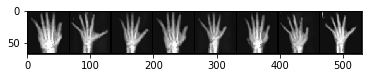

Epoch: 91	Batch: 165/166
Loss G: 8.520751953125
Loss D: 0.018679816275835037
Epoch: 92/110
Example images:


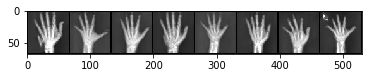

Epoch: 92	Batch: 165/166
Loss G: 8.183879852294922
Loss D: 0.005607706494629383
Epoch: 93/110
Example images:


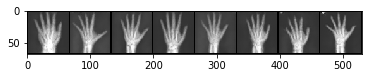

Epoch: 93	Batch: 165/166
Loss G: 5.999245643615723
Loss D: 0.06021180748939514
Epoch: 94/110
Example images:


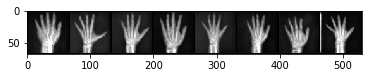

Epoch: 94	Batch: 165/166
Loss G: 11.233631134033203
Loss D: 0.0005870137247256935
Epoch: 95/110
Example images:


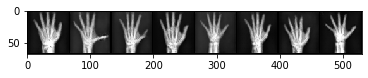

Epoch: 95	Batch: 165/166
Loss G: 1.6201019287109375
Loss D: 0.10514349490404129
Epoch: 96/110
Example images:


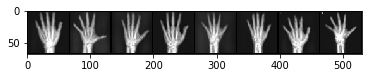

Epoch: 96	Batch: 165/166
Loss G: 7.804820537567139
Loss D: 0.00676112063229084
Epoch: 97/110
Example images:


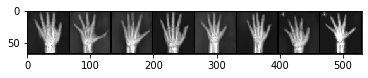

Epoch: 97	Batch: 165/166
Loss G: 9.144513130187988
Loss D: 0.001028676051646471
Epoch: 98/110
Example images:


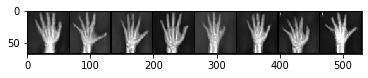

Epoch: 98	Batch: 165/166
Loss G: 7.296301364898682
Loss D: 0.009616582654416561
Epoch: 99/110
Example images:


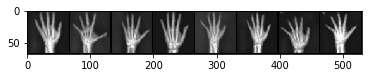

Epoch: 99	Batch: 165/166
Loss G: 5.713311195373535
Loss D: 0.023933935910463333
Epoch: 100/110
Example images:


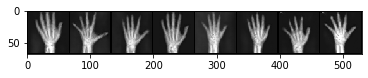

Epoch: 100	Batch: 165/166
Loss G: 6.3692216873168945
Loss D: 0.0065330821089446545
Epoch: 101/110
Example images:


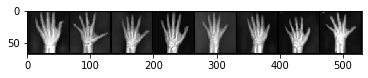

Epoch: 101	Batch: 165/166
Loss G: 7.790156841278076
Loss D: 0.0023305676877498627
Epoch: 102/110
Example images:


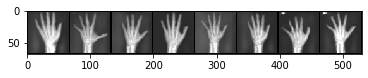

Epoch: 102	Batch: 165/166
Loss G: 6.027300834655762
Loss D: 0.012972081080079079
Epoch: 103/110
Example images:


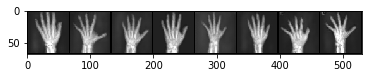

Epoch: 103	Batch: 165/166
Loss G: 9.27688980102539
Loss D: 0.0007181576802395284
Epoch: 104/110
Example images:


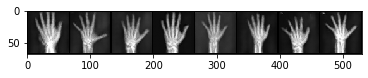

Epoch: 104	Batch: 165/166
Loss G: 5.025031566619873
Loss D: 0.08794328570365906
Epoch: 105/110
Example images:


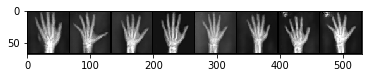

Epoch: 105	Batch: 165/166
Loss G: 7.286375522613525
Loss D: 0.0245821550488472
Epoch: 106/110
Example images:


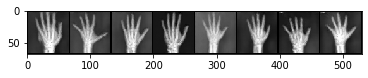

Epoch: 106	Batch: 165/166
Loss G: 15.6032075881958
Loss D: 1.8062856197357178
Epoch: 107/110
Example images:


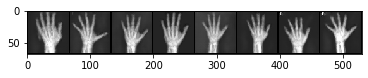

Epoch: 107	Batch: 165/166
Loss G: 9.78495979309082
Loss D: 0.20205122232437134
Epoch: 108/110
Example images:


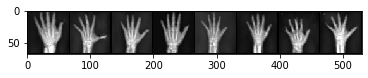

Epoch: 108	Batch: 165/166
Loss G: 6.027790069580078
Loss D: 0.025090880692005157
Epoch: 109/110
Example images:


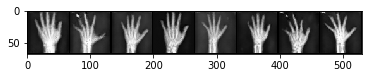

Epoch: 109	Batch: 165/166
Loss G: 5.707347393035889
Loss D: 0.03701680526137352


In [14]:
for epoch in range(n_epochs):
    print(f"Epoch: {epoch}/{n_epochs}")
    print("Example images:")
    generated_images = G(test_noise).detach().cpu()
    show_images(generated_images)
    
    for i, (batch, _) in enumerate(data_loader):
        print(f"\rEpoch: {epoch}\tBatch: {i}/{len(data_loader)}", end='')
        ####
        D.zero_grad()

        #
        real = Variable(batch).to(gpu)
        real_labels = Variable(torch.ones(real.size(0), 1, 1, 1)).to(gpu)
        real_predictions = D(real)
        d_error_real = compute_loss(real_predictions, real_labels)
        
        # 
        noise = Variable(torch.randn(real.size(0), 100, 1, 1)).to(gpu)
        fake = G(noise)
        fake_predictions = D(fake.detach())
        fake_labels = Variable(torch.zeros(real.size(0), 1, 1, 1)).to(gpu)
        d_error_fake = compute_loss(fake_predictions, fake_labels)
        
        # 
        d_error_total = d_error_real + d_error_fake
        d_error_total.backward()
        optimizer_d.step()
        
        ####
        G.zero_grad()
        
        # 
        goal_labels = Variable(torch.ones(real.size(0), 1, 1, 1)).to(gpu)
        results = D(fake)
        g_error = compute_loss(results, goal_labels)
        
        # 
        g_error.backward()
        optimizer_g.step()
    
    print("")
    print(f"Loss G: {g_error}")
    print(f"Loss D: {d_error_total}")

In [ ]:
# torch.save(G.state_dict(), "tmdhey_trained_generator")
# torch.save(D.state_dict(), "tmdhey_trained_discriminator")

In [15]:
torch.save(G.state_dict(), "/content/drive/MyDrive/cakd_colab/python_practice/tmdhey_trained_generator_2")
torch.save(D.state_dict(), "/content/drive/MyDrive/cakd_colab/python_practice/tmdhey_trained_discriminator_2")

# Try trained GAN

In [ ]:
import torchvision
import torch
from torch import nn

In [ ]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            
            # Hidden Layer 1
            nn.ConvTranspose2d(in_channels=100, 
                               out_channels=512,
                               kernel_size=4,
                               stride=1,
                               padding=0,
                               bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            
            # Hidden Layer 2
            nn.ConvTranspose2d(in_channels=512,
                               out_channels=256,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            
            # Hidden Layer 3
            nn.ConvTranspose2d(in_channels=256,
                               out_channels=128,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            
            # Hidden Layer 4
            nn.ConvTranspose2d(in_channels=128,
                               out_channels=64,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            
            # Output Layer
            nn.ConvTranspose2d(in_channels=64, 
                               out_channels=1,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.main(x)
        return x

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(images):
    img = torchvision.utils.make_grid(images, normalize=True)
    npy_img = img.numpy()
    plt.imshow(np.transpose(npy_img, (1, 2, 0)),
               interpolation='nearest')
    plt.show()

In [16]:
G = Generator()
G.load_state_dict(torch.load('/content/drive/MyDrive/cakd_colab/python_practice/tmdhey_trained_generator_2'))

<All keys matched successfully>

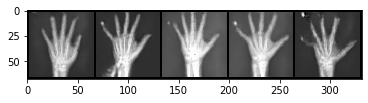

In [19]:
noise = torch.randn(5, 100, 1, 1)

images = G(noise).detach()
images.shape

show_images(images)